## Challenge: Identifying the type of toxicity in the comments for Jigsaw, Google

#### Building a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models.

#### The dataset is of comments from Wikipedia’s talk page edits. 

#### Improvements to the current model will hopefully help online discussion become more productive and respectful.

### This notebook is for supporting Jigsaw:

https://jigsaw.google.com/

Jigsaw is a unit within Google that explores threats to open societies, and builds technology that inspires scalable solutions.

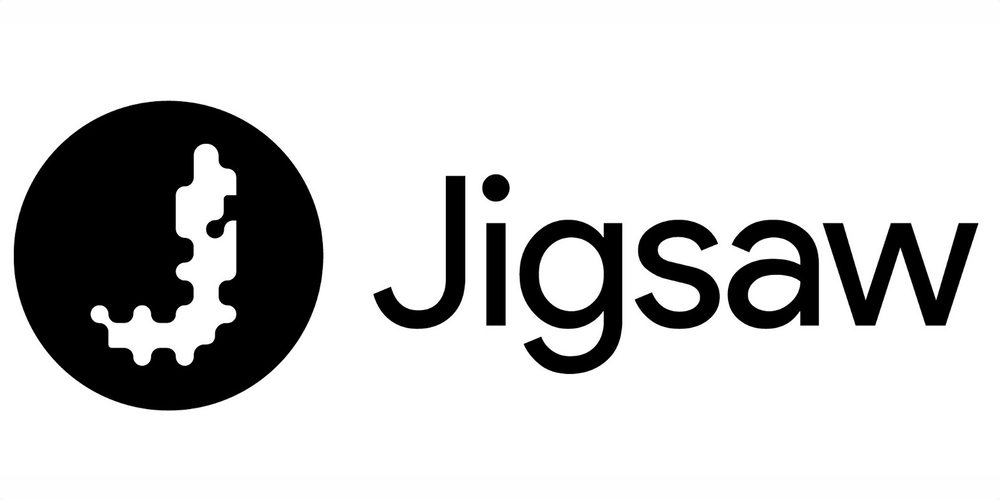

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import zipfile

sample_submission_zip = "../input/jigsaw-toxic-comment-classification-challenge/sample_submission.csv.zip"
test_zip = "../input/jigsaw-toxic-comment-classification-challenge/test.csv.zip"
train_zip = "../input/jigsaw-toxic-comment-classification-challenge/train.csv.zip"
test_labels_zip = "../input/jigsaw-toxic-comment-classification-challenge/test_labels.csv.zip"

for file in [sample_submission_zip, test_zip, train_zip, test_labels_zip]:
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall('./input/csv_files/')
    zip_ref.close()

In [ ]:
print(os.listdir('./input/csv_files/'))

train = pd.read_csv("./input/csv_files/train.csv")
test = pd.read_csv("./input/csv_files/test.csv")
test_labels = pd.read_csv("./input/csv_files/test_labels.csv")
sample_submission = pd.read_csv("./input/csv_files/sample_submission.csv")

In [ ]:
train.head(20)

In [ ]:
train.iloc[2]["comment_text"]

In [ ]:
test.head(5)

In [ ]:
test_labels.head(5)

In [ ]:
sample_submission.head(5)

In [ ]:
print(train.shape)
print(test.shape)

In [ ]:
# check for nulls
print(train.isnull().any(), "\n")
print(test_labels.isnull().any())

In [ ]:
for col_name in ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']:
    print("For", col_name, '\n')
    print(train[col_name].value_counts())
    print("\n")

## Method 1:  Using Keras LSTM

In [ ]:
import sys, os, re, csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Keras imports**

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Activation
from keras.layers import GlobalMaxPool1D, Bidirectional
from keras.models import Model

from keras import initializers, optimizers, regularizers, constraints, layers

<b><li> We cannot remove punctuations (like quotes, exclamation mark), special characters(@*%) or digits since those are key in identifying toxic words. 
<br><li> We also cannot lower case words as uppercase might indicate comments written in anger or frustration 
<br><li> So we will just remove the essential english stop-words </b>

In [ ]:
import spacy
# removing some functions from nlp since we have over 1 lakh comments and that would take up a lot of time
nlp = spacy.load("en_core_web_lg", disable=["parser", "tagger", "ner"])

def clean_text(text):
    
    # Processing text with the nlp object returns a Doc object that holds all information about the tokens, 
    # their linguistic features and their relationships.
    doc = nlp(text)
    
    # getting tokens, lemmatizing words and eliminating basic english stop-words
    tokens=[token.lemma_.strip() for token in doc if 
            not token.is_stop and not nlp.vocab[token.lemma_].is_stop
            ] # Removing only StopWords
        
    # Recreation of the text
    text=" ".join(tokens)

    # Returning the text
    return text


train["comment_text"] = train["comment_text"].apply(lambda x: clean_text(x))
test["comment_text"] = test["comment_text"].apply(lambda x: clean_text(x))

train.head(20)

In [ ]:
list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]

all_train_classes_values = train[list_classes].values

list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

In [ ]:
list_sentences_train

**Pre-processing of words in comments to feed it to the LSTM model**

1. Tokenization
2. Indexing
3. Index Representation - Getting sentence of indexed words

So this is what we are going to do:

<li><b>Tokenization</b> - We need to break down the sentence into unique words. For eg, "I love cats and love dogs" will become ["I","love","cats","and","dogs"]
    <br><li><b>Indexing</b> - We put the words in a dictionary-like structure and give them an index each For eg, {1:"I",2:"love",3:"cats",4:"and",5:"dogs"}
        <br><li><b>Index Representation</b>- We could represent the sequence of words in the comments in the form of index, and feed this chain of index into our LSTM. For eg, [1,2,3,4,2,5]

In [ ]:
from keras.preprocessing.text import Tokenizer

# Intialize the Tokenizer by specifying the maximum number of unique words it can take for forming the dictionary 
max_features = 20000

# Intialize tokenizer object
tokenizer = Tokenizer(num_words = max_features)

# Fit tokenizer on the list of train comments
tokenizer.fit_on_texts(list(list_sentences_train))

# Get tokenized words
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [ ]:
count = 0

for i in list_tokenized_train:
    if count <= 5:
        print(i)
        print("\n")
    count += 1 

In [ ]:
# Summary of word counts
from more_itertools import take

take(10, tokenizer.word_counts.items())

In [ ]:
# Indices associated with words

take(10,tokenizer.word_index.items())

In [ ]:
len(tokenizer.word_counts)

#### By using stop word removal we reduced the noise in the data from a total 210337 words to 173827
#### That is the noise reduction was done by 17.35%

As we can observe all sequences/statements are of different length so we need <b>Padding</b> and <b> Shortening </b> of very long sentences.
<br><br> This needs to be done to get all sentences of equal length so that they could be later fed to an LSTM model. Also, we cannot pad to maximum length sentence since that would create a highly sparse matrix and we cannot shorten it to very short lengths because that would lead us lose information and thus affect accuracy.

In [ ]:
sentenceLength = [len(one_comment) for one_comment in list_tokenized_train]

plt.hist(sentenceLength, bins = np.arange(0, 410, 10))

In [ ]:
# We can take a safe bet on the max length of the sentence by taking the number 3 std dev away from the mean
np.mean(sentenceLength) + 3*np.std(sentenceLength)

In [ ]:
from keras.preprocessing.sequence import pad_sequences

max_sen_len = 173

X_train = pad_sequences(list_tokenized_train, maxlen = max_sen_len)
X_test = pad_sequences(list_tokenized_test, maxlen = max_sen_len)

In [ ]:
X_train

In [ ]:
max_features

### Building the LSTM model

In [ ]:
from keras.layers import Dense, Dropout, Input, LSTM, Embedding, Activation
from keras.layers import GlobalMaxPool1D, Bidirectional
from keras.models import Model
from keras.models import Sequential

from keras import initializers, optimizers, regularizers, constraints, layers

model = Sequential()


# Embedding takes input dimension, output dimension, input maximum length
embedding = Embedding(max_features, # max_features are 20000 in number
                      128, 
                      input_length = max_sen_len)
model.add(embedding)
# The embedding layer outputs a 3-D matrix of dimensions None*173*128
# None indicates that its size is inferred
# 173 is the sequence length 
# 128 indicates that for each of the 173 words in the sequence we have 128 coordinates associated with each word in the sequence


# LSTM layer takes the output of embedding layer and generates a matrix of None*173*60 where 60 is taken as the output dimension
model.add(LSTM(60, return_sequences = True))


# Using Max Pooling to reduce dimensions from 3D to 2D
model.add(GlobalMaxPool1D())


# Now adding Dense and Dropout layers
model.add(Dropout(0.1))
model.add(Dense(50, activation = "relu"))
model.add(Dropout(0.1))

# Adding the final Dense layer with 6 classes and sigmoid activation function
model.add(Dense(6, activation="sigmoid"))

# Since we are tackling binary classification problem we use loss as binary_crossentropy
model.compile(loss="binary_crossentropy",
             optimizer="adam",
             metrics=["accuracy"])
# The default learning rate is 0.001

In [ ]:
# To check for correct input and output dimensions for each layer
model.summary()

In [ ]:
# To view any layer's output
from keras import backend as K

get_3rd_layer_ouput = K.function([model.layers[0].input],
                                 [model.layers[2].output])

# Passing one comment and checking the output 
layer_output = get_3rd_layer_output([X_train[:1]])[0]
layer_output.shape

In [ ]:
# Running the model with 10% validation set

# 32 sentences/comments will be passed in each batch
batch_size = 32 

# 2 iterations
epochs = 2

model.fit(X_train, all_train_classes_values, batch_size = batch_size, epochs = epochs, validation_split = 0.1)

**Accuracy of the training and validation sets are good so we can proceed with prediction**

In [ ]:
y_pred = model.predict(X_test)
y_pred

In [ ]:
sample_submission[list_classes] = y_pred
sample_submission.head(10)

In [ ]:
list_classes

In [ ]:
# Adding a threshold of 0.5 for each category
def threshold_conversion(x):
    output = 0
    if x>0.5:
        output = 1
    else:
        ouput = 0
    return output

sample_submission['toxic'] = sample_submission['toxic'].apply(lambda x: threshold_conversion(x))
sample_submission['severe_toxic'] = sample_submission['severe_toxic'].apply(lambda x: threshold_conversion(x))
sample_submission['obscene'] = sample_submission['obscene'].apply(lambda x: threshold_conversion(x))
sample_submission['threat'] = sample_submission['threat'].apply(lambda x: threshold_conversion(x))
sample_submission['insult'] = sample_submission['insult'].apply(lambda x: threshold_conversion(x))
sample_submission['identity_hate'] = sample_submission['identity_hate'].apply(lambda x: threshold_conversion(x))
sample_submission.head(10)

## References:

1. https://www.kaggle.com/muhardianabasandi/lstm-jigsaw-toxiccomment-classification
2. https://www.kaggle.com/sbongo/for-beginners-tackling-toxic-using-keras
3. https://www.kaggle.com/jhoward/improved-lstm-baseline-glove-dropout
4. https://www.kaggle.com/sbongo/do-pretrained-embeddings-give-you-the-extra-edge/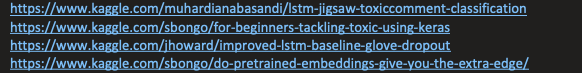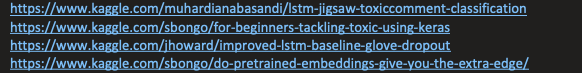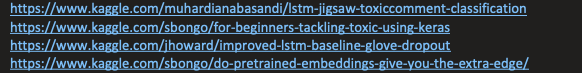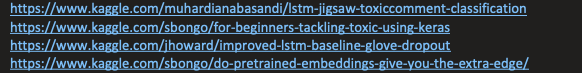